# SVM Fake News Classifier - Classificação de Notícias Externas

Este notebook utiliza o modelo SVM treinado para classificar notícias da base externa `party_news.parquet`.

## Objetivo
Carregar o modelo SVM já treinado e aplicá-lo na base de dados externa para detectar possíveis fake news, com **análises detalhadas por partido político**.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Configurar cores para os gráficos
COLORS = {'fake': '#e74c3c', 'true': '#2ecc71', 'neutral': '#3498db'}

## 1. Carregar Modelo e Vetorizador

In [8]:
# Carregar o modelo SVM treinado
with open('../models/svm_fake_news_classifier.pkl', 'rb') as f:
    svm_model = pickle.load(f)

# Carregar o vetorizador TF-IDF
with open('../models/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

print("Modelo e vetorizador carregados com sucesso!")
print(f"Tipo do modelo: {type(svm_model)}")
print(f"Número de features do TF-IDF: {len(tfidf.get_feature_names_out())}")

Modelo e vetorizador carregados com sucesso!
Tipo do modelo: <class 'sklearn.svm._classes.LinearSVC'>
Número de features do TF-IDF: 5000


## 2. Carregar Dados Externos (Party News)

In [9]:
# Carregar dados externos
df_external = pd.read_parquet('../data/external/party_news.parquet')

# where published_at_as_date year is 2016, 2017, 2018
df_external = df_external[(df_external['published_at_as_date'].dt.year >= 2016) & (df_external['published_at_as_date'].dt.year <= 2018)]


print(f"Shape dos dados externos: {df_external.shape}")
print(f"\nColunas disponíveis: {df_external.columns.tolist()}")
print(f"\nPrimeiras linhas:")
df_external.head()

Shape dos dados externos: (22145, 11)

Colunas disponíveis: ['id', 'title', 'subtitle', 'published_at', 'published_at_as_date', 'content', 'url', 'created_at', 'created_at_as_date', 'author', 'preprocessed_text']

Primeiras linhas:


,id,title,subtitle,published_at,published_at_as_date,content,url,created_at,created_at_as_date,author,preprocessed_text
5,113157,Reimont Otoni: Energia é soberania,A ofensiva contra a Eletrobras parece um teste...,10/05/2018 16h18,2018-05-10 16:18:00,Temer quer privatizar a Eletrobras\n\nO govern...,https://pt.org.br/reimont-otoni-energia-e-sobe...,2026-01-17 18:52:15,2026-01-17 18:52:15.908117,pt.org.br,temer quer privatizar eletrobras governo golpi...
16,93098,Floriano Vieira da Silva: O resgate,"Temos que reafirmar, junto à sociedade brasile...",10/01/2017 08h00,2017-01-10 08:00:00,Ato em Pernambuco pela democracia e contra o g...,https://pt.org.br/floriano-vieira-da-silva-o-r...,2026-01-17 18:46:06,2026-01-17 18:46:06.215832,pt.org.br,ato pernambuco democracia contra golpe foto di...
20,117750,“Vem de Cuba” retrata a atuação do Mais Médico...,"Produzido de maneira independente, o documentá...",01/10/2017 08h44,2017-10-01 08:44:00,"Produzido de maneira independente, o documentá...",https://pt.org.br/vem-de-cuba-retrata-a-atuaca...,2026-01-17 18:53:49,2026-01-17 18:53:49.230081,pt.org.br,produzido maneira independente documentario mo...
23,134030,"Com apoio da bancada do PSDB, Congresso Nacion...",Tucanos comemoraram a decisão e criticaram as ...,2016-10-19,2016-10-19 00:00:00,"Com apoio do PSDB, o Congresso aprovou o Proje...",https://www.psdb.org.br/acompanhe/noticias/com...,2026-01-17 19:00:31,2026-01-17 19:00:31.715269,psdb.org.br,apoio psdb congresso aprovou projeto lei pln a...
29,143237,Encontro reuniu lideranças do PSDB e partidos ...,,2016-03-18,2016-03-18 00:00:00,Durante toda a manhã desta sexta-feira (18/03)...,https://www.psdb.org.br/acompanhe/encontro-reu...,2026-01-17 19:04:40,2026-01-17 19:04:40.922050,psdb.org.br,durante toda manha desta sexta feira psdb real...


In [10]:
# Verificar informações sobre os dados
print("Informações sobre os dados:")
df_external.info()

print("\nEstatísticas descritivas:")
df_external.describe()

Informações sobre os dados:
<class 'pandas.core.frame.DataFrame'>
Index: 22145 entries, 5 to 117845
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    22145 non-null  int64         
 1   title                 22145 non-null  object        
 2   subtitle              22145 non-null  object        
 3   published_at          22145 non-null  object        
 4   published_at_as_date  22145 non-null  datetime64[ns]
 5   content               22145 non-null  object        
 6   url                   22145 non-null  object        
 7   created_at            22145 non-null  object        
 8   created_at_as_date    22145 non-null  datetime64[ns]
 9   author                22145 non-null  object        
 10  preprocessed_text     22145 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 2.0+ MB

Estatísticas descritivas:


,id,published_at_as_date,created_at_as_date
count,22145.000000,22145,22145
mean,122717.532716,2017-06-12 12:05:56.225784576,2026-01-17 18:57:52.973823232
min,75958.000000,2016-01-01 00:00:00,2026-01-17 18:42:03.218814
25%,95677.000000,2016-08-23 00:00:00,2026-01-17 18:46:48.888808960
50%,115221.000000,2017-05-11 00:00:00,2026-01-17 18:52:57.606885120
75%,150031.000000,2018-04-27 12:44:00,2026-01-17 19:07:50.010469888
max,186746.000000,2018-12-31 23:50:00,2026-01-17 19:34:00.678746
std,31971.515947,NaN,NaN


## 3. Preparar Dados para Classificação

In [11]:
# Verificar se existe coluna de texto pré-processado
# Ajustar o nome da coluna conforme necessário
text_column = None
for col in ['preprocessed_text']:
    if col in df_external.columns:
        text_column = col
        break

if text_column is None:
    raise ValueError("Não foi encontrada coluna de texto nos dados!")

print(f"Usando coluna: {text_column}")

# Remover valores nulos
df_clean = df_external[df_external[text_column].notna() & (df_external[text_column] != '')].copy()
print(f"\nDados após limpeza: {df_clean.shape}")
print(f"Registros removidos: {len(df_external) - len(df_clean)}")

Usando coluna: preprocessed_text

Dados após limpeza: (22091, 11)
Registros removidos: 54


## 4. Vetorizar Textos

In [12]:
# Vetorizar os textos usando o TF-IDF já treinado
X_external = tfidf.transform(df_clean[text_column].values)

print(f"Shape da matriz TF-IDF: {X_external.shape}")
print(f"Número de documentos: {X_external.shape[0]}")
print(f"Número de features: {X_external.shape[1]}")

Shape da matriz TF-IDF: (22091, 5000)
Número de documentos: 22091
Número de features: 5000


## 5. Fazer Predições

In [13]:
# Fazer predições
predictions = svm_model.predict(X_external)

# Adicionar predições ao dataframe
df_clean['is_fake_prediction'] = predictions
df_clean['prediction_label'] = df_clean['is_fake_prediction'].map({0: 'True', 1: 'Fake'})

# Contar predições
print("Distribuição das predições:")
print(df_clean['is_fake_prediction'].value_counts())
print("\nPorcentagem:")
print(df_clean['is_fake_prediction'].value_counts(normalize=True) * 100)

Distribuição das predições:
is_fake_prediction
0    11923
1    10168
Name: count, dtype: int64

Porcentagem:
is_fake_prediction
0    53.972206
1    46.027794
Name: proportion, dtype: float64


## 6. Análise Geral dos Resultados

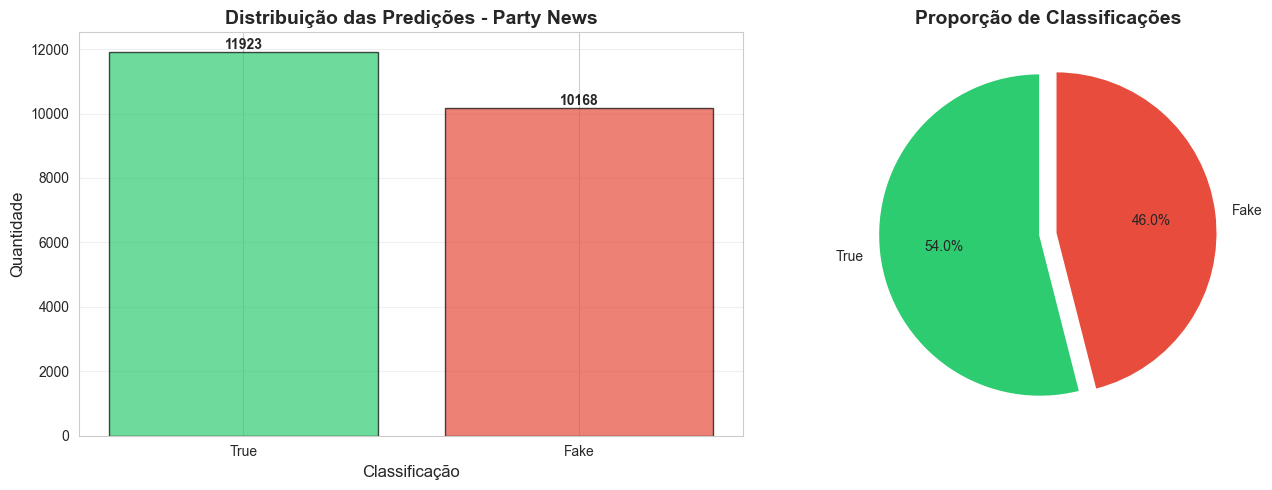

In [14]:
# Visualizar distribuição geral das predições
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
counts = df_clean['prediction_label'].value_counts()
colors = [COLORS['true'], COLORS['fake']]
axes[0].bar(counts.index, counts.values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribuição das Predições - Party News', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classificação', fontsize=12)
axes[0].set_ylabel('Quantidade', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Gráfico de pizza
axes[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=(0.05, 0.05))
axes[1].set_title('Proporção de Classificações', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Análise Detalhada por Partido

In [15]:
# Identificar coluna de partido
party_column = None
for col in ['author']:
    if col in df_clean.columns:
        party_column = col
        break

if party_column:
    print(f"✓ Coluna de partido encontrada: '{party_column}'")
    print(f"\nPartidos únicos: {df_clean[party_column].nunique()}")
    print(f"\nLista de partidos:\n{df_clean[party_column].unique()}")
else:
    print("⚠ Coluna de partido não encontrada. Análise por partido será pulada.")

✓ Coluna de partido encontrada: 'author'

Partidos únicos: 2

Lista de partidos:
['pt.org.br' 'psdb.org.br']


### 7.1. Tabela Resumo por Partido

In [16]:
if party_column:
    # Criar análise detalhada por partido
    party_analysis = df_clean.groupby(party_column).agg({
        'is_fake_prediction': ['count', 'sum', 'mean']
    }).round(4)
    
    party_analysis.columns = ['Total_Notícias', 'Fake_Count', 'Fake_Rate']
    party_analysis['True_Count'] = party_analysis['Total_Notícias'] - party_analysis['Fake_Count']
    party_analysis['Fake_Percentage'] = (party_analysis['Fake_Rate'] * 100).round(2)
    party_analysis['True_Percentage'] = (100 - party_analysis['Fake_Percentage']).round(2)
    
    # Reordenar colunas
    party_analysis = party_analysis[[
        'Total_Notícias', 
        'True_Count', 'True_Percentage',
        'Fake_Count', 'Fake_Percentage'
    ]]
    
    # Ordenar por porcentagem de fake news (decrescente)
    party_analysis = party_analysis.sort_values('Fake_Percentage', ascending=False)
    
    print("="*100)
    print("ANÁLISE DETALHADA POR PARTIDO")
    print("="*100)
    print(party_analysis.to_string())
    print("="*100)

ANÁLISE DETALHADA POR PARTIDO
             Total_Notícias  True_Count  True_Percentage  Fake_Count  Fake_Percentage
author                                                                               
pt.org.br             12061        5525            45.81        6536            54.19
psdb.org.br           10030        6398            63.79        3632            36.21


### 7.2. Gráficos Comparativos por Partido

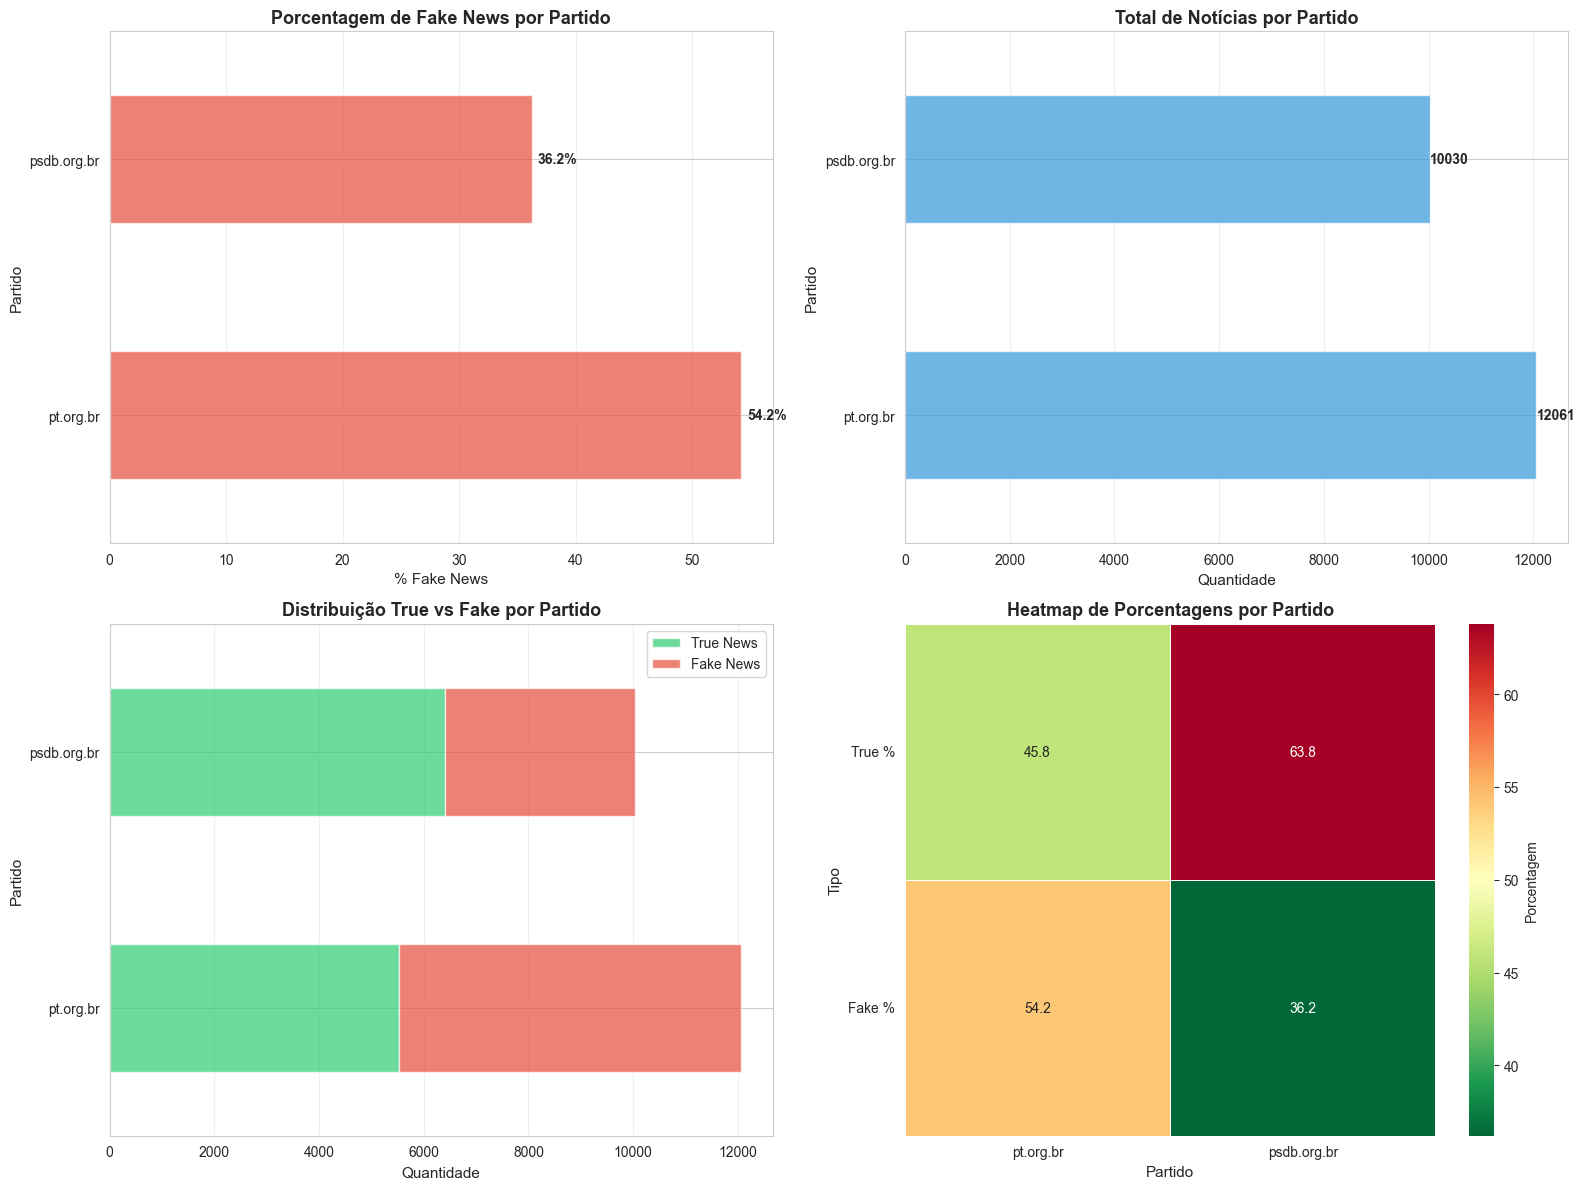

In [17]:
if party_column:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Porcentagem de Fake News por Partido
    ax1 = axes[0, 0]
    party_analysis['Fake_Percentage'].plot(kind='barh', ax=ax1, color=COLORS['fake'], alpha=0.7)
    ax1.set_title('Porcentagem de Fake News por Partido', fontsize=13, fontweight='bold')
    ax1.set_xlabel('% Fake News', fontsize=11)
    ax1.set_ylabel('Partido', fontsize=11)
    ax1.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(party_analysis['Fake_Percentage'].values):
        ax1.text(v + 0.5, i, f'{v:.1f}%', va='center', fontweight='bold')
    
    # 2. Total de Notícias por Partido
    ax2 = axes[0, 1]
    party_analysis['Total_Notícias'].plot(kind='barh', ax=ax2, color=COLORS['neutral'], alpha=0.7)
    ax2.set_title('Total de Notícias por Partido', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Quantidade', fontsize=11)
    ax2.set_ylabel('Partido', fontsize=11)
    ax2.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(party_analysis['Total_Notícias'].values):
        ax2.text(v + 0.5, i, str(int(v)), va='center', fontweight='bold')
    
    # 3. Comparação Fake vs True por Partido (Stacked Bar)
    ax3 = axes[1, 0]
    party_counts = party_analysis[['True_Count', 'Fake_Count']]
    party_counts.plot(kind='barh', stacked=True, ax=ax3, 
                      color=[COLORS['true'], COLORS['fake']], alpha=0.7)
    ax3.set_title('Distribuição True vs Fake por Partido', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Quantidade', fontsize=11)
    ax3.set_ylabel('Partido', fontsize=11)
    ax3.legend(['True News', 'Fake News'], loc='best')
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Heatmap de Porcentagens
    ax4 = axes[1, 1]
    heatmap_data = party_analysis[['True_Percentage', 'Fake_Percentage']].T
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'Porcentagem'}, ax=ax4, linewidths=0.5)
    ax4.set_title('Heatmap de Porcentagens por Partido', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Tipo', fontsize=11)
    ax4.set_xlabel('Partido', fontsize=11)
    ax4.set_yticklabels(['True %', 'Fake %'], rotation=0)
    
    plt.tight_layout()
    plt.show()

### 7.3. Ranking de Partidos por Fake News

In [18]:
if party_column:
    print("\n" + "="*80)
    print("RANKING DE PARTIDOS POR PORCENTAGEM DE FAKE NEWS")
    print("="*80)
    
    ranking = party_analysis[['Total_Notícias', 'Fake_Count', 'Fake_Percentage']].copy()
    ranking['Posição'] = range(1, len(ranking) + 1)
    ranking = ranking[['Posição', 'Total_Notícias', 'Fake_Count', 'Fake_Percentage']]
    
    print(ranking.to_string())
    print("="*80)
    
    # Estatísticas do ranking
    print(f"\n📊 Estatísticas do Ranking:")
    print(f"   • Partido com MAIOR % de fake news: {ranking.index[0]} ({ranking.iloc[0]['Fake_Percentage']:.2f}%)")
    print(f"   • Partido com MENOR % de fake news: {ranking.index[-1]} ({ranking.iloc[-1]['Fake_Percentage']:.2f}%)")
    print(f"   • Média de fake news: {ranking['Fake_Percentage'].mean():.2f}%")
    print(f"   • Mediana de fake news: {ranking['Fake_Percentage'].median():.2f}%")
    print(f"   • Desvio padrão: {ranking['Fake_Percentage'].std():.2f}%")


RANKING DE PARTIDOS POR PORCENTAGEM DE FAKE NEWS
             Posição  Total_Notícias  Fake_Count  Fake_Percentage
author                                                           
pt.org.br          1           12061        6536            54.19
psdb.org.br        2           10030        3632            36.21

📊 Estatísticas do Ranking:
   • Partido com MAIOR % de fake news: pt.org.br (54.19%)
   • Partido com MENOR % de fake news: psdb.org.br (36.21%)
   • Média de fake news: 45.20%
   • Mediana de fake news: 45.20%
   • Desvio padrão: 12.71%


### 7.4. Análise Temporal por Partido (se disponível)

✓ Coluna de data encontrada: 'published_at_as_date'


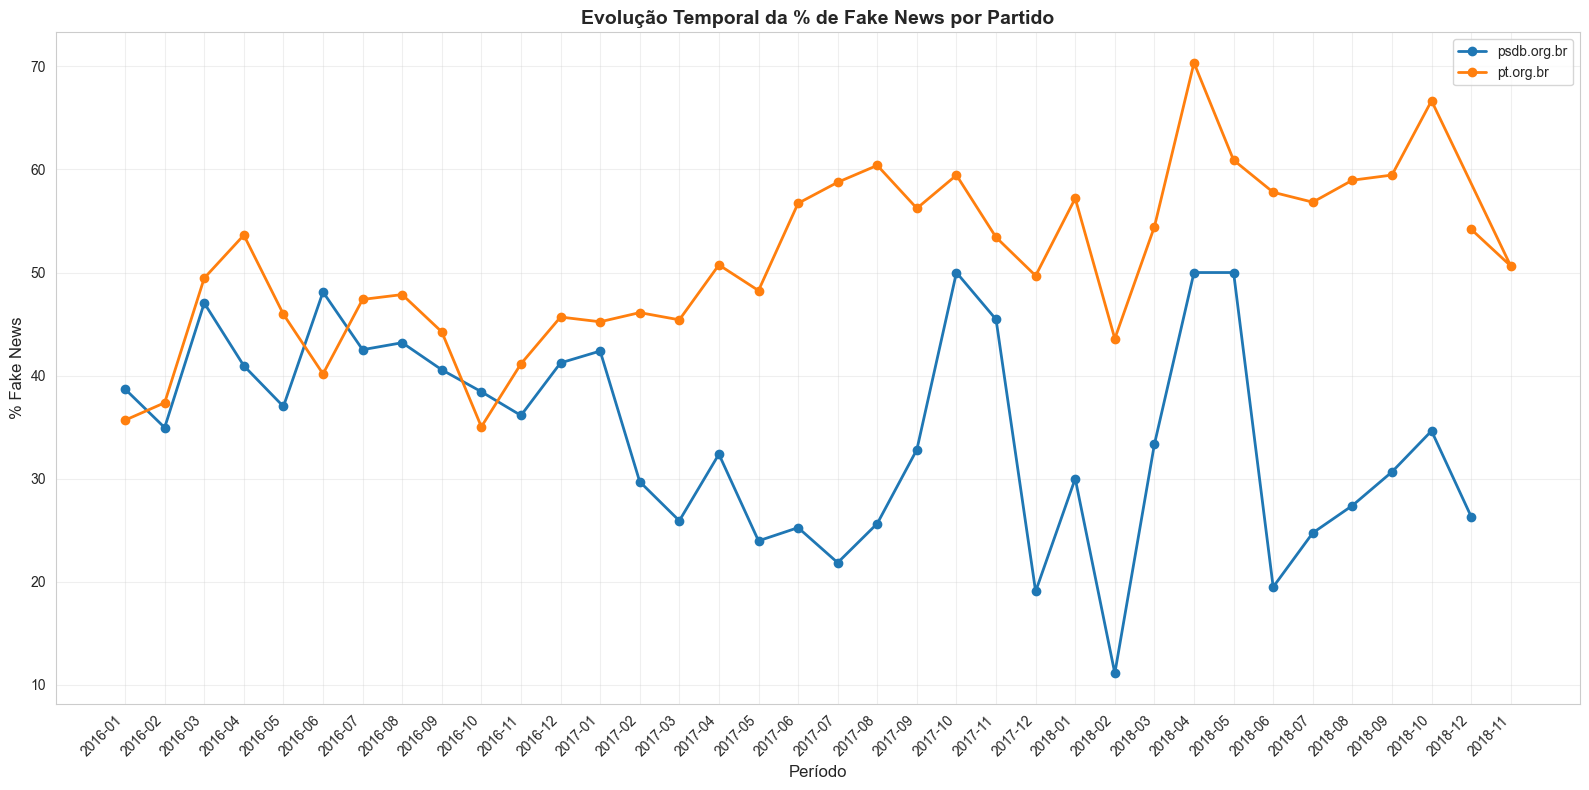

In [19]:
if party_column:
    # Verificar se existe coluna de data
    date_column = None
    for col in ['published_at_as_date']:
        if col in df_clean.columns:
            date_column = col
            break
    
    if date_column:
        print(f"✓ Coluna de data encontrada: '{date_column}'")
        
        # Converter para datetime se necessário
        df_clean[date_column] = pd.to_datetime(df_clean[date_column], errors='coerce')
        df_clean['year_month'] = df_clean[date_column].dt.to_period('M')
        
        # Análise temporal por partido
        temporal_analysis = df_clean.groupby([party_column, 'year_month'])['is_fake_prediction'].agg(['count', 'sum']).reset_index()
        temporal_analysis.columns = [party_column, 'Período', 'Total', 'Fake_Count']
        temporal_analysis['Fake_Percentage'] = (temporal_analysis['Fake_Count'] / temporal_analysis['Total'] * 100).round(2)
        
        # Plotar evolução temporal
        fig, ax = plt.subplots(figsize=(16, 8))
        
        for party in temporal_analysis[party_column].unique():
            party_data = temporal_analysis[temporal_analysis[party_column] == party]
            ax.plot(party_data['Período'].astype(str), party_data['Fake_Percentage'], 
                   marker='o', label=party, linewidth=2)
        
        ax.set_title('Evolução Temporal da % de Fake News por Partido', fontsize=14, fontweight='bold')
        ax.set_xlabel('Período', fontsize=12)
        ax.set_ylabel('% Fake News', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠ Coluna de data não encontrada. Análise temporal será pulada.")

### 7.5. Análise de Palavras-Chave por Partido (Top Fake News)

In [20]:
if party_column:
    print("\n" + "="*100)
    print("TOP 10 PALAVRAS MAIS FREQUENTES EM FAKE NEWS POR PARTIDO")
    print("="*100)
    
    fake_news_df = df_clean[df_clean['is_fake_prediction'] == 1]
    
    for party in party_analysis.index[:5]:  # Top 5 partidos com mais fake news
        party_fake = fake_news_df[fake_news_df[party_column] == party]
        
        if len(party_fake) > 0:
            # Concatenar todos os textos
            all_text = ' '.join(party_fake[text_column].astype(str).values)
            
            # Contar palavras (filtrar palavras muito curtas)
            words = [word for word in all_text.split() if len(word) > 3]
            word_counts = Counter(words).most_common(10)
            
            print(f"\n🔸 {party} ({len(party_fake)} fake news):")
            for i, (word, count) in enumerate(word_counts, 1):
                print(f"   {i:2d}. {word:20s} - {count:3d} ocorrências")


TOP 10 PALAVRAS MAIS FREQUENTES EM FAKE NEWS POR PARTIDO

🔸 pt.org.br (6536 fake news):
    1. lula                 - 18771 ocorrências
    2. presidente           - 8291 ocorrências
    3. brasil               - 7971 ocorrências
    4. noticia              - 5068 ocorrências
    5. compartilhe          - 4918 ocorrências
    6. contra               - 4812 ocorrências
    7. governo              - 4787 ocorrências
    8. nacional             - 4586 ocorrências
    9. pais                 - 4576 ocorrências
   10. povo                 - 4296 ocorrências

🔸 psdb.org.br (3632 fake news):
    1. presidente           - 4536 ocorrências
    2. psdb                 - 3883 ocorrências
    3. governo              - 3733 ocorrências
    4. brasil               - 3023 ocorrências
    5. pais                 - 2993 ocorrências
    6. dilma                - 2841 ocorrências
    7. federal              - 2582 ocorrências
    8. tambem               - 2252 ocorrências
    9. paulo                - 1

### 7.6. Matriz de Correlação entre Partidos

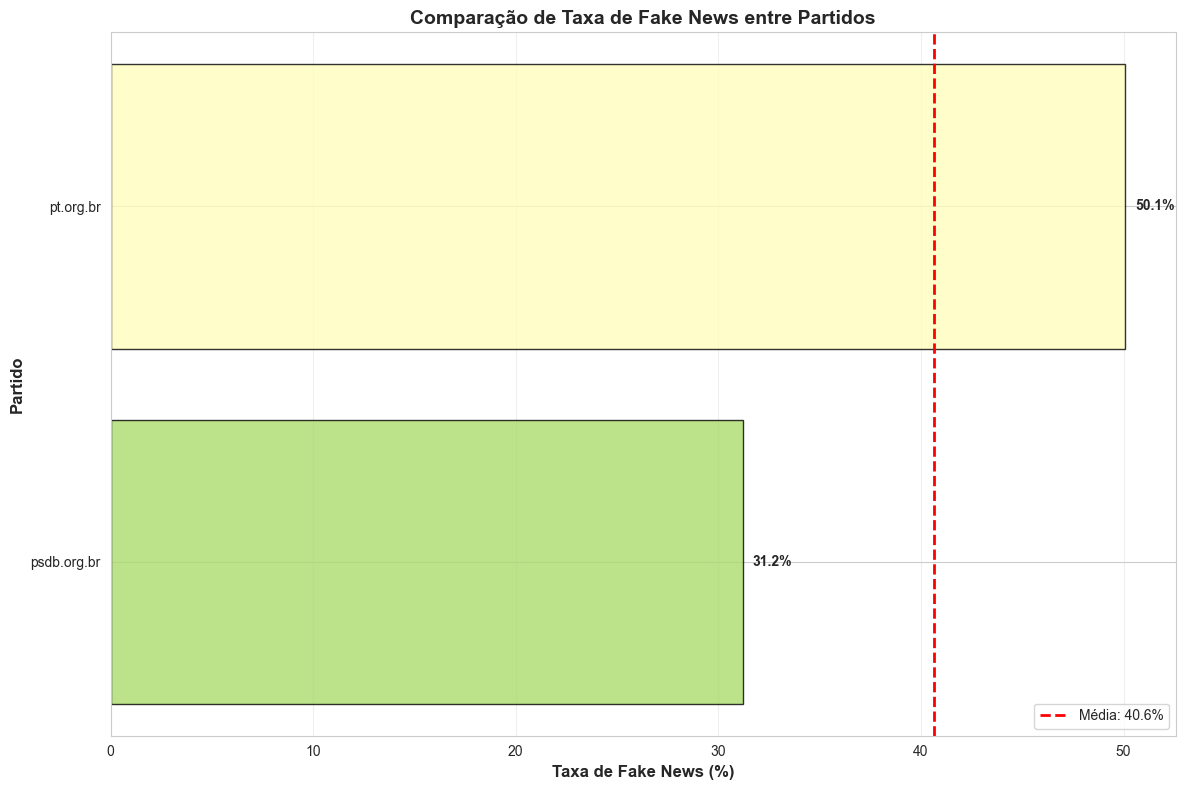

In [53]:
if party_column:
    # Criar matriz pivot para correlação
    pivot_data = df_clean.groupby([party_column])['is_fake_prediction'].mean()
    
    # Criar gráfico de comparação
    fig, ax = plt.subplots(figsize=(12, 8))
    
    parties = pivot_data.index.tolist()
    values = pivot_data.values * 100
    
    # Criar gradiente de cores baseado nos valores
    colors_gradient = plt.cm.RdYlGn_r(values / 100)
    
    bars = ax.barh(parties, values, color=colors_gradient, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Taxa de Fake News (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Partido', fontsize=12, fontweight='bold')
    ax.set_title('Comparação de Taxa de Fake News entre Partidos', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar linha de média
    mean_value = values.mean()
    ax.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_value:.1f}%')
    ax.legend()
    
    # Adicionar valores nas barras
    for i, (party, value) in enumerate(zip(parties, values)):
        ax.text(value + 0.5, i, f'{value:.1f}%', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 8. Exemplos de Notícias Classificadas como Fake por Partido

In [54]:
if party_column:
    fake_news = df_clean[df_clean['is_fake_prediction'] == 1]
    
    print(f"\nTotal de notícias classificadas como FAKE: {len(fake_news)}")
    print("\n" + "="*100)
    print("EXEMPLOS DE FAKE NEWS POR PARTIDO (2 exemplos por partido)")
    print("="*100)
    
    for party in party_analysis.index[:5]:  # Top 5 partidos
        party_fake = fake_news[fake_news[party_column] == party]
        
        if len(party_fake) > 0:
            print(f"\n🔴 {party} - {len(party_fake)} fake news identificadas")
            print("-" * 100)
            
            for idx, row in party_fake.head(2).iterrows():
                print(f"\n   Exemplo {idx + 1}:")
                print(f"   Texto: {row[text_column][:300]}...")
                if date_column and date_column in row:
                    print(f"   Data: {row[date_column]}")
                print()
else:
    # Mostrar exemplos gerais se não houver coluna de partido
    fake_news = df_clean[df_clean['is_fake_prediction'] == 1]
    
    print(f"Total de notícias classificadas como FAKE: {len(fake_news)}")
    print("\nExemplos de notícias classificadas como FAKE:\n")
    
    for idx, row in fake_news.head(10).iterrows():
        print(f"{'='*80}")
        print(f"Texto: {row[text_column][:200]}...")
        print()


Total de notícias classificadas como FAKE: 9196

EXEMPLOS DE FAKE NEWS POR PARTIDO (2 exemplos por partido)

🔴 pt.org.br - 6066 fake news identificadas
----------------------------------------------------------------------------------------------------

   Exemplo 4800:
   Texto: Compartilhe noticia:...
   Data: 2018-08-24 16:07:00


   Exemplo 4857:
   Texto: Compartilhe noticia:...
   Data: 2017-05-10 17:57:00


🔴 psdb.org.br - 3130 fake news identificadas
----------------------------------------------------------------------------------------------------

   Exemplo 12:
   Texto: Recife (PE) – Pernambuco perdeu 5.255 vagas emprego formal mes passado. 31.775 admissoes, contra 37.030 demissoes, deixa 2016 saldo negativo 45.710 postos trabalho. dados sao Cadastro Geral Empregados Desempregados (Caged) Ministerio Trabalho registrou somente abril, todo pais, perda 62,844 mil post...
   Data: 2016-05-26 00:00:00


   Exemplo 14:
   Texto: venezuelanos vivem verdadeiro caos social capitan

## 9. Salvar Resultados

In [ ]:
# Salvar resultados em um novo arquivo
output_path = '../data/processed/party_news_classified.parquet'
df_clean.to_parquet(output_path, index=False)
print(f"✓ Resultados salvos em: {output_path}")

# Salvar também um CSV com apenas as fake news
fake_news_path = '../data/processed/party_news_fake_only.csv'
fake_news.to_csv(fake_news_path, index=False)
print(f"✓ Fake news salvas em: {fake_news_path}")

# Salvar análise por partido
if party_column:
    party_analysis_path = '../data/processed/party_analysis_summary.csv'
    party_analysis.to_csv(party_analysis_path)
    print(f"✓ Análise por partido salva em: {party_analysis_path}")

## 10. Resumo Final

In [31]:
print("="*100)
print("RESUMO FINAL DA CLASSIFICAÇÃO")
print("="*100)
print(f"\n📊 ESTATÍSTICAS GERAIS:")
print(f"   • Total de notícias analisadas: {len(df_clean):,}")
print(f"   • Notícias classificadas como TRUE: {(df_clean['is_fake_prediction'] == 0).sum():,}")
print(f"   • Notícias classificadas como FAKE: {(df_clean['is_fake_prediction'] == 1).sum():,}")
print(f"   • Porcentagem de FAKE news: {(df_clean['is_fake_prediction'].mean() * 100):.2f}%")
print(f"   • Porcentagem de TRUE news: {((1 - df_clean['is_fake_prediction'].mean()) * 100):.2f}%")

if party_column:
    print(f"\n🏛️ ESTATÍSTICAS POR PARTIDO:")
    print(f"   • Total de partidos analisados: {df_clean[party_column].nunique()}")
    print(f"   • Partido com MAIOR % fake news: {party_analysis.index[0]} ({party_analysis.iloc[0]['Fake_Percentage']:.2f}%)")
    print(f"   • Partido com MENOR % fake news: {party_analysis.index[-1]} ({party_analysis.iloc[-1]['Fake_Percentage']:.2f}%)")
    print(f"   • Média de fake news entre partidos: {party_analysis['Fake_Percentage'].mean():.2f}%")
    print(f"   • Desvio padrão: {party_analysis['Fake_Percentage'].std():.2f}%")

print("\n" + "="*100)
print("✓ Análise concluída com sucesso!")
print("="*100)

RESUMO FINAL DA CLASSIFICAÇÃO

📊 ESTATÍSTICAS GERAIS:
   • Total de notícias analisadas: 117,849
   • Notícias classificadas como TRUE: 72,448
   • Notícias classificadas como FAKE: 45,401
   • Porcentagem de FAKE news: 38.52%
   • Porcentagem de TRUE news: 61.48%

🏛️ ESTATÍSTICAS POR PARTIDO:
   • Total de partidos analisados: 3
   • Partido com MAIOR % fake news: partidoliberal.org.br (51.74%)
   • Partido com MENOR % fake news: psdb.org.br (35.89%)
   • Média de fake news entre partidos: 42.49%
   • Desvio padrão: 8.25%

✓ Análise concluída com sucesso!
